In [25]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils import benchmark
import pandas as pd
import matplotlib.pyplot as plt

# from condensed_sparsity.models import LinearCondensed

In [19]:
import pickle
threads = 1
device = "cpu"
compiler = "inductor"
dtype="torch.float32"
file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final.pkl"
with open(f"../{file_name}", "rb") as handle:
    compare = pickle.load(handle)
print(compare)

[---------------------------------------------------------------------------------------------------------------------------------- Sparsity 99 with 1 threads using compilation strategy inductor and dtype torch.float32 on device cpu. ----------------------------------------------------------------------------------------------------------------------------------]
                     |  Dense benchmark - eager  |  Structured sparsity - eager  |  structured + csr - eager  |  Vmap - eager  |  Fine-grained + structured - eager  |  Dense benchmark - Compiled - backend inductor  |  Structured sparsity compiled with backend - inductor  |  structured + csr with backend inductor  |  Fine-grained + structured with backend inductor
1 threads: -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

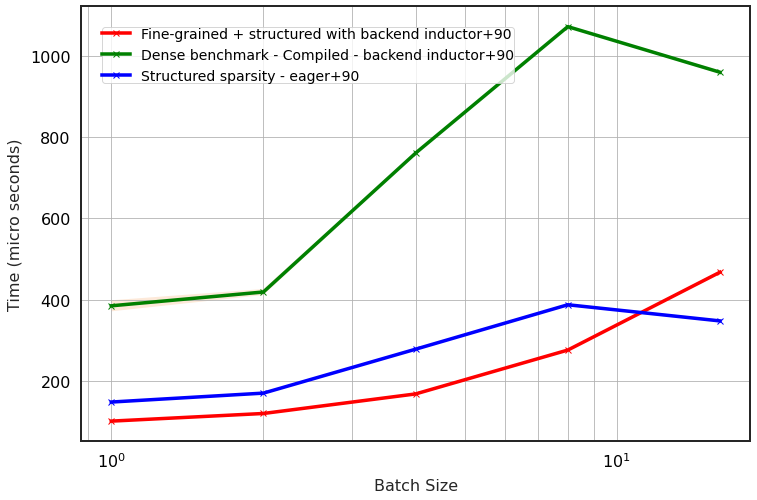

In [20]:
import re
import pandas as pd
import numpy as np
plt.style.use("../plt_plot_style.mplstyle")
target_descriptions = [
    "Fine-grained + structured with backend inductor",
    # "structured + csr with backend inductor",
    "Structured sparsity - eager",
    "Dense benchmark - Compiled - backend inductor",
    # "Structured sparsity compiled with backend - inductor",
    # "Vmap - eager"
]
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}
for measurement in compare._results:
    sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
    sparsity = sparsity_match.groups()[0]

    thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
    threads = thread_match.groups()[0]
    desc = measurement.description
    if int(sparsity) not in [90,]:
        continue
    if desc not in target_descriptions:
        continue
    if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) !=90:
        continue
    data["description"].append(desc)
    data["sparsity"].append(int(sparsity))
    batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
    data["batch_size"].append(int(batch))
    data["num_features"].append(int(num_features))
    data["time"].append(measurement.median*1e6)
    data["std"].append(np.std(measurement.times)*1e6)
df = pd.DataFrame(data)
df = df.sort_values(by="batch_size", ascending=True)
fig, ax = plt.subplots(figsize=(12,8))
df = df.loc[df["batch_size"]<=16]  # TODO: Also sort by desc?
lines = ["solid", "dashed", "dashdot", "dotted"]
colours = ["red", "green", "blue", "orange"]
for i, d in enumerate(df["description"].unique()):
    colour = colours[i]
    for ii, s in enumerate(df["sparsity"].unique()):
        line = lines[ii]
        df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
        # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
        if len(df_slice) > 0:
            ax.plot(df_slice["batch_size"], df_slice["time"], label=f"{d}+{s}", marker="x", ls=line, color=colour)
            ax.fill_between(
                df_slice["batch_size"],
                df_slice["time"]+df_slice["std"],
                df_slice["time"]-df_slice["std"],
                alpha=0.2
            )
plt.legend()
plt.ylabel("Time (micro seconds)")
plt.xlabel("Batch Size")
plt.grid(True, which="both")

# plt.title(f"{result_type.upper()} Benchmark")
ax.set_xscale("log")
# ax.set_yscale("log")
plt.show()
fig.savefig("cpu_benchmark_v2.png", dpi=400, transparent=False)


In [31]:
df

,sparsity,batch_size,num_features,time,std,description
35,90,1,768,104.744206,5.552676,Fine-grained + structured with backend inductor
34,90,1,768,121.890142,2.588391,Dense benchmark - Compiled - backend inductor
33,90,1,768,68.912651,9.126397,Structured sparsity - eager
32,90,2,768,134.067026,5.398164,Fine-grained + structured with backend inductor
31,90,2,768,130.613528,1.925560,Dense benchmark - Compiled - backend inductor
30,90,2,768,337.936577,0.000000,Structured sparsity - eager
29,90,4,768,151.261842,19.722250,Fine-grained + structured with backend inductor
28,90,4,768,119.211739,34.846111,Dense benchmark - Compiled - backend inductor
27,90,4,768,58.314600,422.493495,Structured sparsity - eager
25,90,8,768,142.395469,48.938755,Dense benchmark - Compiled - backend inductor


In [17]:
## GPU Timings
import pickle
threads = 1
device = "gpu"
compiler = "inductor"
dtype="torch.float32"
file_name = f"benchmark_v2_{device}_threads_{threads}_compiler_{compiler}_dtype_{dtype}final.pkl"
with open(f"../{file_name}", "rb") as handle:
    compare = pickle.load(handle)
print(compare)

[---------------------------------------------------------------------------------------------------------------------------------- Sparsity 99 with 1 threads using compilation strategy inductor and dtype torch.float32 on device cuda. ---------------------------------------------------------------------------------------------------------------------------------]
                     |  Dense benchmark - eager  |  Structured sparsity - eager  |  structured + csr - eager  |  Vmap - eager  |  Fine-grained + structured - eager  |  Dense benchmark - Compiled - backend inductor  |  Structured sparsity compiled with backend - inductor  |  structured + csr with backend inductor  |  Fine-grained + structured with backend inductor
1 threads: -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

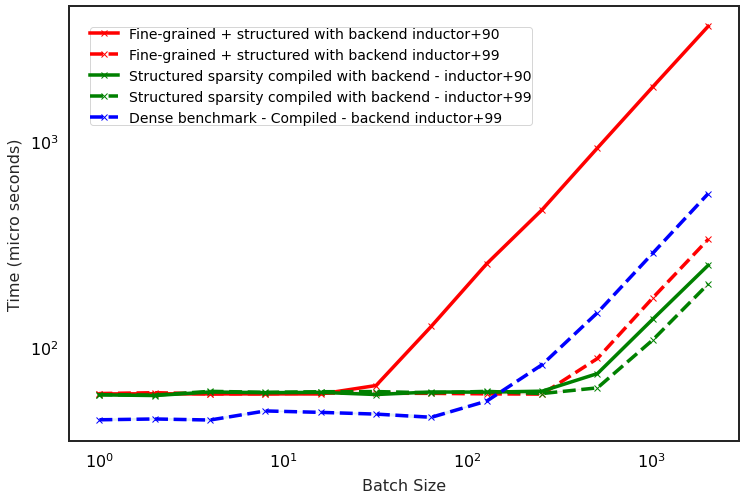

In [18]:
import re
import pandas as pd
import numpy as np
plt.style.use("../plt_plot_style.mplstyle")
target_descriptions = [
    "Fine-grained + structured with backend inductor",
    # "structured + csr with backend inductor",
    "Dense benchmark - Compiled - backend inductor",
    "Structured sparsity compiled with backend - inductor",
    # "Vmap - eager"
]
data = {
    "sparsity": [],
    "batch_size": [],
    "num_features": [],
    "time": [],
    "std": [],
    "description": []
}
for measurement in compare._results:
    sparsity_match = re.match(f"Sparsity ([0-9]*)", measurement.title)
    sparsity = sparsity_match.groups()[0]

    thread_match = re.match(f".*with ([0-9]*) threads.*", measurement.title)
    threads = thread_match.groups()[0]
    desc = measurement.description
    if int(sparsity) == 80:
        continue
    if desc not in target_descriptions:
        continue
    if desc == "Dense benchmark - Compiled - backend inductor" and int(sparsity) !=99:
        continue
    data["description"].append(desc)
    data["sparsity"].append(int(sparsity))
    batch, num_features = re.findall(r"[0-9]+", measurement.sub_label)
    data["batch_size"].append(int(batch))
    data["num_features"].append(int(num_features))
    data["time"].append(measurement.median*1e6)
    data["std"].append(np.std(measurement.times)*1e6)
df = pd.DataFrame(data)
df = df.sort_values(by="batch_size", ascending=True)
fig, ax = plt.subplots(figsize=(12,8))
df = df.loc[df["batch_size"]<=2048]  # TODO: Also sort by desc?
lines = ["solid", "dashed", "dashdot", "dotted"]
colours = ["red", "green", "blue", "orange"]
for i, d in enumerate(df["description"].unique()):
    colour = colours[i]
    for ii, s in enumerate(df["sparsity"].unique()):
        line = lines[ii]
        df_slice = df.loc[(df["sparsity"] == s) & (df["description"]==d)]
        # df_slice = df_slice.groupby("batch_size").agg(mean_time=("time", "mean"), std_time=("time", "std")).reset_index()
        if len(df_slice) > 0:
            ax.plot(df_slice["batch_size"], df_slice["time"], label=f"{d}+{s}", marker="x", ls=line, color=colour)
            ax.fill_between(
                df_slice["batch_size"],
                df_slice["time"]+df_slice["std"],
                df_slice["time"]-df_slice["std"],
                alpha=0.2
            )
plt.legend()
plt.ylabel("Time (micro seconds)")
plt.xlabel("Batch Size")
# plt.title(f"{result_type.upper()} Benchmark")
ax.set_xscale("log")
ax.set_yscale("log")
plt.show()
fig.savefig("gpu_benchmark_v2.png", dpi=400, transparent=False)
